# Reinforcement for supply Chain

- Mehdi El Kansouli
- Victor Girou
- Samule Pariente

In this notebook we will developp an experiment to test the robustness of our model with respect to he observation it used to predict the action.

## Import 

In [11]:
from agent.DQN import ReplayBuffer, DQN
from environment.env import SupplyChainV0
import numpy as np
import torch
import matplotlib.pyplot as plt
from agent_trainer.main_trainer import training_dqn
from agent_trainer.utils import *

## Environment parameters

In order to use DQN we need to first discretize our action space. We will take 6 values for our actions with a max value of 200.

In [12]:
n_actions = 6
action_max_value = 200
single_possible_actions = [int(action_max_value/(n_actions-1))*i for i in range(n_actions)]

## Experiment 1

In the following experiment we can train an agent if we want and evaluate it. Before going further we need to set the number of distributors. 

In [13]:
train_agent = False
n_distributors = 2

In [14]:
suppliers = {
    'distrib_'+str(k+1): {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": lambda x: 0.5*x, 
    "sell_price": 5.
    }
    for k in range(n_distributors)}

env = SupplyChainV0(suppliers, 125*n_distributors)
env_eval = SupplyChainV0(suppliers, 125*n_distributors)

if train_agent:

    replay_buffer_capacity = 1e6
    D = ReplayBuffer(replay_buffer_capacity)

    # network parameters 
    obs_space_dim = n_distributors*2
    action_space_size = n_actions**n_distributors
    hidden_dim = 256

    model = DQN(action_space_dim=action_space_size, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network = DQN(action_space_dim=action_space_size, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network.load_state_dict(model.state_dict())

    trained_agent, losses, rewards = training_dqn(
        env=env,
        env_eval=env_eval,
        model=model,
        target_network=target_network,
        D=D,
        actions_discrete=single_possible_actions, 
        n_distributors=n_distributors,
        episode_length=100,
        gamma=0.9, 
        n_steps=100000, 
        tau=0.6,
        batch_size=32)
    torch.save(trained_agent, './saved_models/DQN_' + str(n_distributors) + '_distributors.pt')

    
    figs, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot([l.detach().numpy() for l in losses])
    axs[0].set_title('Evolution of the loss during training')
    axs[1].plot(np.arange(len(rewards)), rewards)
    axs[1].set_ylabel('Total Reward')
    axs[1].set_xlabel('Episodes')
    axs[1].set_title('Evolution of Reward during training')

Lets' load a model to evaluate it:

In [15]:
model = torch.load('./saved_models/DQN_' + str(n_distributors) + '_distributors.pt')

In [16]:
episode_length = 100
reward_eval_dqn_list = []
profit_eval_dqn_list = [] 

for i in range(100):
    env_eval = SupplyChainV0(suppliers, 125*n_distributors)

    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []
    possible_actions = possible_actions_func(single_possible_actions, n_distributors)

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)

We can plot the reward on the different evaluations:

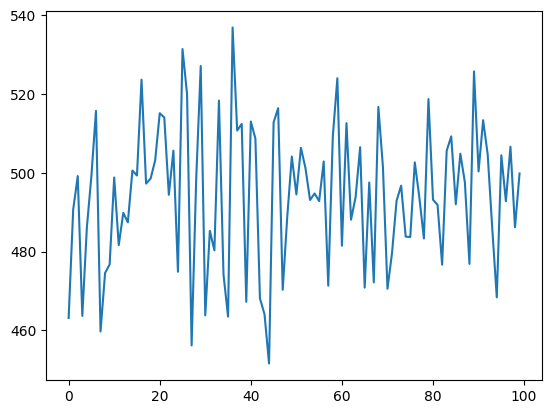

In [17]:
plt.plot(reward_eval_dqn_list)

## Experiment 2

In this section we will evaluate the robstness with respect to the observation. We can recall that the observation the agent receive to make its prediction is an estimation of the demand to which we add a gaussian noise. We will increase the standard deviation of the noise and observe how the agent react by focusing on the quarterial profit.
To run the following cells we need to have trained a agent for a ceratin number of distributors.

In [18]:
n_distributors = 2
suppliers = {
        'distrib_'+str(k+1): {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0.5*x, 
        "sell_price": 5.
    }
    for k in range(n_distributors)}
noises = np.arange(5, 500, 20)

In [19]:

model = torch.load('./saved_models/DQN_'+str(n_distributors)+'_distributors.pt')
profit = {}
episode_length = 1000

for noise in noises:

    env_eval = SupplyChainV0(suppliers, 125*n_distributors, noise=noise)

    reward_eval_dqn_list = []
    profit_eval_dqn_list = []

    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []
    possible_actions = possible_actions_func(single_possible_actions, n_distributors)

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)

    profit[noise] = profit_episode

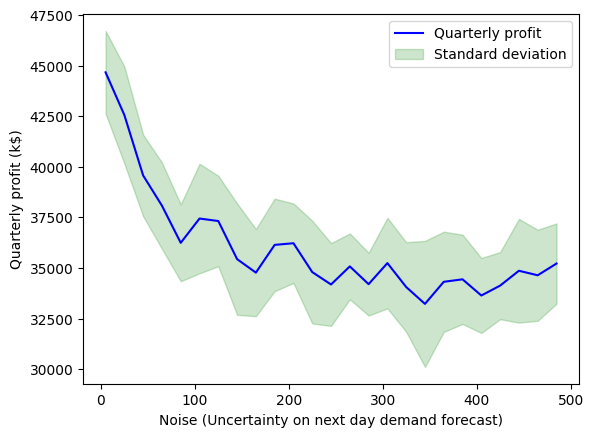

In [20]:
indicator_list = np.array([moving_average(np.array(val), 90) for val in profit.values()])
std_array = indicator_list[:, 1]
mean_array = indicator_list[:, 0]


plt.plot(noises, mean_array, color='blue', label='Quarterly profit')
plt.fill_between(noises, mean_array-std_array, mean_array+std_array, alpha=0.2, color='green', label='Standard deviation')
plt.xlabel('Noise (Uncertainty on next day demand forecast)')
plt.ylabel('Quarterly profit (k$)')
plt.legend()